In [2]:
from read_gestures import load_data 
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import random_split

import torch 
from torch.utils.data import TensorDataset , DataLoader
import torch.nn as nn
import torch.optim as optim

from read_gestures_test import load_data_exp
from itertools import chain

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

In [2]:
class RadarLstm(nn.Module):
    def __init__(self , input_size , hidden_size , num_layers , num_classes , dropout:float=0.2): 
        super().__init__()
        
        self.lstm = nn.LSTM(input_size , hidden_size , num_layers , batch_first=True , bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2 , num_classes)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        h_lstm,_ = self.lstm(x)
        output = h_lstm[:,1,:]
        output = self.dropout(output)
        output = self.fc(output)
        output = self.logsoftmax(output)
        
        return output

In [ ]:
data , labels = load_data()

data   = np.array(data)
labels = np.array(labels)

data_tensor   = torch.tensor(data,dtype=torch.float32)
labels_tensor = torch.tensor(labels,dtype=torch.long)

dataset = TensorDataset(data_tensor,labels_tensor) ## dataset ready to do the job :)

## Splitting the dataset into train and test data 90% / 10% 
train_size = int(0.9*len(dataset))
test_size  = len(dataset) - train_size

train_data , test_data = random_split(dataset,[train_size,test_size])

train_loader = DataLoader(train_data , batch_size=32 , shuffle=True)
test_loader = DataLoader(test_data , batch_size=32 , shuffle=True)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


In [5]:
from collections import Counter
print(Counter(labels_tensor.tolist()))

Counter({4: 402, 0: 401, 9: 401, 11: 401, 1: 400, 5: 400, 6: 400, 7: 400, 8: 400, 10: 400, 3: 304, 2: 300})


In [6]:
print(f'Full dataset size: {len(dataset)}')
print(f'Train dataset size: {len(train_data)}')
print(f'Test dataset size: {len(test_data)}')
print("")
sample, label = dataset[0]
print(f'Input sample shape: {sample.size()}')  # (80, 160)
print(f'Label shape: {label.size()}')          # ()

print("")
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx}: Inputs shape {targets.shape}")
    print(inputs[15])
    print(targets[1])
    if batch_idx==1 : 
        break

Full dataset size: 4609
Train dataset size: 4148
Test dataset size: 461

Input sample shape: torch.Size([80, 160])
Label shape: torch.Size([])

Batch 0: Inputs shape torch.Size([32])
tensor([[0.2871, 0.2852, 0.2676,  ..., 0.0000, 0.0000, 0.0000],
        [0.2852, 0.2852, 0.2871,  ..., 0.0000, 0.0000, 0.0000],
        [0.2852, 0.2852, 0.2871,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
tensor(5)
Batch 1: Inputs shape torch.Size([32])
tensor([[-0.0352, -0.0391, -0.0449,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0137,  0.0000, -0.0137,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1055,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
       

In [8]:
### Defining the model 
model = RadarLstm(input_size=160 , hidden_size=128 , num_layers=2 , num_classes=12 , dropout=0.2)
model = model.to(device)
print(model)

criterion =nn.NLLLoss() ## LogSoftmax --> NLLoss
optimizer = optim.Adam(model.parameters() , lr=0.001)


num_epochs = 50


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_count = 0
    for batch_data , batch_labels in train_loader :
        
        optimizer.zero_grad()
        batch_data   = batch_data.to(device)
        batch_labels = batch_labels.to(device)
    
        outputs = model(batch_data)
        loss    = criterion(outputs , batch_labels)
        
        loss.backward() 
        optimizer.step()
        total_loss += loss.item()
        batch_count += 1
    avg_loss = total_loss / batch_count
    print(f"Epoch [{epoch+1}/{num_epochs}] -- {batch_count} batches processed -- Average Loss: {avg_loss:.4f}")

RadarLstm(
  (lstm): LSTM(160, 128, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=12, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)
Epoch [1/50] -- 130 batches processed -- Average Loss: 1.5237
Epoch [2/50] -- 130 batches processed -- Average Loss: 0.6219
Epoch [3/50] -- 130 batches processed -- Average Loss: 0.4958
Epoch [4/50] -- 130 batches processed -- Average Loss: 0.4906
Epoch [5/50] -- 130 batches processed -- Average Loss: 0.3870
Epoch [6/50] -- 130 batches processed -- Average Loss: 0.3606
Epoch [7/50] -- 130 batches processed -- Average Loss: 0.3398
Epoch [8/50] -- 130 batches processed -- Average Loss: 0.3056
Epoch [9/50] -- 130 batches processed -- Average Loss: 0.2668
Epoch [10/50] -- 130 batches processed -- Average Loss: 0.2481
Epoch [11/50] -- 130 batches processed -- Average Loss: 0.2345
Epoch [12/50] -- 130 batches processed -- Average Loss: 0.2444
Epoch [13/50] -- 130 batch

Accuracy: 0.9370932754880694
Precision (macro): 0.9397772415030233
Recall (macro): 0.9402192123122356
F1 Score (macro): 0.9391796918638864

Confusion Matrix:
 [[40  3  0  0  0  0  0  0  0  0  0  0]
 [ 4 39  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 26  0  0  0  0  0  0  0  0  0]
 [ 0  2  0 24  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 33  2  0  0  0  0  0  0]
 [ 0  0  0  0  3 34  0  0  0  0  2  0]
 [ 0  0  1  0  0  0 44  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 38  0  0  0  1]
 [ 0  1  0  0  0  1  0  0 43  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  1  0  0  0  0 33  1]
 [ 0  1  0  0  0  0  0  0  0  3  3 42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92        43
           1       0.85      0.91      0.88        43
           2       0.96      1.00      0.98        26
           3       1.00      0.92      0.96        26
           4       0.92      0.94      0.93        35
           5       0.8

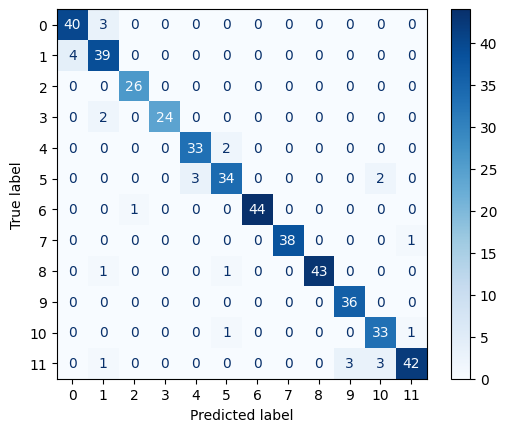

In [ ]:
## Evaluation 
model.eval()
all_preds    = []
all_targets = []

with torch.no_grad():
    for batch_udx , (inputs , targets) in enumerate(test_loader) : 
        inputs = inputs.to(device)
        targets = targets.to(device) 
        
        outs = model(inputs)
        _,predicted = torch.max(outs,1)
        all_preds.append(predicted.cpu())
        all_targets.append(targets.cpu())
        
all_preds = torch.cat(all_preds)    
all_targets = torch.cat(all_targets)

y_true = np.array(all_targets)
y_pred = np.array(all_preds)
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))

print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(all_targets,all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)    
plt.show()



In [ ]:
## Evaluation with the new measured hand gesture samples ==> "hand closer – taking a hand closer to the radar"

data , labels = load_data_exp()

data   = np.array(data)
labels = np.array(labels)

data_tensor   = torch.tensor(data,dtype=torch.float32)
labels_tensor = torch.tensor(labels,dtype=torch.long)

dataset = TensorDataset(data_tensor,labels_tensor)

exp_loader = DataLoader(dataset , batch_size=3 , shuffle=True)

Accuracy: 0.9320594479830149
Precision (macro): 0.9348101714834859
Recall (macro): 0.935721857814881
F1 Score (macro): 0.9343880633046521

Confusion Matrix:
 [[40  3  0  0  0  0  0  0  0  0  0  0]
 [ 4 39  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 26  0  0  0  0  0  0  0  0  0]
 [ 0  2  0 24  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 40  2  0  3  0  0  0  0]
 [ 0  0  0  0  3 34  0  0  0  0  2  0]
 [ 0  0  1  0  0  0 44  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 38  0  0  0  1]
 [ 0  1  0  0  0  1  0  0 43  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  1  0  0  0  0 33  1]
 [ 0  1  0  0  0  0  0  0  0  3  3 42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92        43
           1       0.85      0.91      0.88        43
           2       0.96      1.00      0.98        26
           3       1.00      0.92      0.96        26
           4       0.93      0.89      0.91        45
           5       0.89

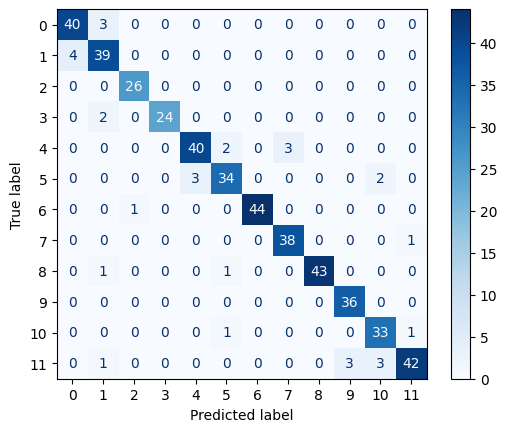

In [ ]:
model.eval()
all_preds    = []
all_targets = []

with torch.no_grad():
    for batch_udx , (inputs , targets) in enumerate(chain(test_loader,  exp_loader)) : 
        inputs = inputs.to(device)
        targets = targets.to(device) 

        
        outs = model(inputs)
        _,predicted = torch.max(outs,1)
        all_preds.append(predicted.cpu())
        all_targets.append(targets.cpu())
        
all_preds = torch.cat(all_preds)    
all_targets = torch.cat(all_targets)

y_true = np.array(all_targets)
y_pred = np.array(all_preds)
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))

print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(all_targets,all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)    
plt.show()